In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt


torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

## Network

In [3]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(3, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.1),

            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.2),

            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.2),

            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128,256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.2),
            nn.Linear(16384, 256),
            # nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),

            nn.Dropout(p = 0.2),
            nn.Linear(256, 128),
            # nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),

            nn.Dropout(p = 0.1),
            nn.Linear(128, 6),
#             nn.BatchNorm1d(512), not in this model
            nn.Softmax(dim=1)
        )



    def forward(self, x):
        x = self.features(x)
        x = x.reshape(-1, 16384)
        x = self.classifier(x)

        return x

def get_num_correct(pred, label):
    return pred.argmax(dim=1).eq(label).sum().item()

## Moving To GPU

In [4]:
device = torch.device("cuda:0")
print(device)
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

cuda:0
Running on the GPU


# **Test the Model**

## Test Dataset Creation

In [5]:
mean = 0.2069
std = 0.1471

In [6]:
test_data_dir = '/content/drive/My Drive/al5083/al5083/test'

transform_test = transforms.Compose([
     transforms.CenterCrop((800,800)),
     transforms.ToTensor(),
     ])

test_dataset = datasets.ImageFolder(root =test_data_dir,transform = transform_test)
test_dataset

Dataset ImageFolder
    Number of datapoints: 6386
    Root location: /content/drive/My Drive/al5083/al5083/test
    StandardTransform
Transform: Compose(
               CenterCrop(size=(800, 800))
               ToTensor()
           )

## Generating true labels

In [7]:
import json
# Opening JSON file
f = open('/content/drive/My Drive/al5083/al5083/test/test.json',)

label_test = json.load(f)

In [8]:
keys_orig = list(label_test.keys())
values = list(label_test.values())
keys = []
for key in keys_orig:
  a_string = key
  a_string = a_string.replace("/", " ")
  x = a_string.split()
  string = x[0]+' '+x[1]
  keys.append(string)
true_test_labels_dict = {keys[i]: values[i] for i in range(len(keys))}
true_test_labels_dict

{'170906-143512-Al 2mm-part2': 1,
 '170904-155610-Al 2mm': 2,
 '170906-143512-Al 2mm-part1': 2,
 '170904-154202-Al 2mm-part1': 2,
 '170904-150144-Al 2mm-part2': 4,
 '170906-155007-Al 2mm-part2': 4,
 '170913-154448-Al 2mm': 0,
 '170906-113317-Al 2mm-part1': 0,
 '170905-112213-Al 2mm': 0,
 '170906-104925-Al 2mm': 0,
 '170904-152301-Al 2mm-part2': 5,
 '170906-153326-Al 2mm-part3': 3,
 '170906-151724-Al 2mm-part1': 3,
 '170906-155007-Al 2mm-part1': 3}

### 6 Class Test

## Matching the loaded data with Labels

In [9]:
original_test_labels_dict = test_dataset.class_to_idx
original_test_labels_dict

{'170904-150144-Al 2mm-part2': 0,
 '170904-152301-Al 2mm-part2': 1,
 '170904-154202-Al 2mm-part1': 2,
 '170904-155610-Al 2mm': 3,
 '170905-112213-Al 2mm': 4,
 '170906-104925-Al 2mm': 5,
 '170906-113317-Al 2mm-part1': 6,
 '170906-143512-Al 2mm-part1': 7,
 '170906-143512-Al 2mm-part2': 8,
 '170906-151724-Al 2mm-part1': 9,
 '170906-153326-Al 2mm-part3': 10,
 '170906-155007-Al 2mm-part1': 11,
 '170906-155007-Al 2mm-part2': 12,
 '170913-154448-Al 2mm': 13}

## Label Mapping

In [10]:
test_label_map_dict = {}

for key,value in original_test_labels_dict.items():
  test_label_map_dict.update({value:true_test_labels_dict[key]})
test_label_map_dict

{0: 4,
 1: 5,
 2: 2,
 3: 2,
 4: 0,
 5: 0,
 6: 0,
 7: 2,
 8: 1,
 9: 3,
 10: 3,
 11: 3,
 12: 4,
 13: 0}

## Loading The Model

In [11]:
PATH_model = "/content/drive/My Drive/model_classical_train_multi.pt"

In [12]:
import torch
net = Network()
pretrained_dict = torch.load(PATH_model, map_location=device)
model_dict = net.state_dict()

# Filter out layers with mismatched shapes
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}

# Update the current model's state dictionary
model_dict.update(pretrained_dict)
net.load_state_dict(model_dict)
net.to(device)

Network(
  (features): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [13]:
torch.cuda.empty_cache()
torch.set_grad_enabled(False)

## Testing

### 6 Class Test

In [16]:
test_loader1 = DataLoader(test_dataset, batch_size=10,shuffle=True)

In [17]:
total_correct=0
correct_predictions = []
i=0
total = 0
for batch in test_loader1:
  image, label_original = batch
  label = [test_label_map_dict[lab.item()] for lab in label_original]
  label = torch.tensor(label)


  pred = net(image.to(device))

  total_correct += get_num_correct(pred,label.to(device))
  correct_predictions.append(total_correct)

  total += len(label)
  acc = 100*total_correct/(total)
  print('Batch No: ',i+1,'/',len(test_loader1),', Accuracy till Now : ', acc)
  i=i+1
print(total_correct/len(test_dataset))

Batch No:  1 / 639 , Accuracy till Now :  30.0
Batch No:  2 / 639 , Accuracy till Now :  20.0
Batch No:  3 / 639 , Accuracy till Now :  16.666666666666668
Batch No:  4 / 639 , Accuracy till Now :  17.5
Batch No:  5 / 639 , Accuracy till Now :  16.0
Batch No:  6 / 639 , Accuracy till Now :  16.666666666666668
Batch No:  7 / 639 , Accuracy till Now :  15.714285714285714
Batch No:  8 / 639 , Accuracy till Now :  17.5
Batch No:  9 / 639 , Accuracy till Now :  15.555555555555555
Batch No:  10 / 639 , Accuracy till Now :  17.0
Batch No:  11 / 639 , Accuracy till Now :  16.363636363636363
Batch No:  12 / 639 , Accuracy till Now :  15.833333333333334
Batch No:  13 / 639 , Accuracy till Now :  15.384615384615385
Batch No:  14 / 639 , Accuracy till Now :  15.0
Batch No:  15 / 639 , Accuracy till Now :  15.333333333333334
Batch No:  16 / 639 , Accuracy till Now :  15.625
Batch No:  17 / 639 , Accuracy till Now :  15.294117647058824
Batch No:  18 / 639 , Accuracy till Now :  15.0
Batch No:  19 / 6

KeyboardInterrupt: 

In [18]:
total_correct=0
condition = True
for batch in test_loader1:
  if condition:
    image, label_original = batch
    label = [test_label_map_dict[lab.item()] for lab in label_original]
    label = torch.tensor(label)


    pred = net(image.to(device))

    total_correct += get_num_correct(pred,label.to(device))

    condition = False
  else:
    break
label_6class = label
pred_6class = pred.argmax(dim=1)

## Defect Correspoing the label


In [19]:
weld_type = {
    0: 'Good Weld',
    1: 'Defective Weld',
    2: 'Defective Weld',
    3: 'Defective Weld',
    4:'Defective Weld',
    5:'Defective Weld'
}

In [20]:
defect_label = {
    0: 'Good Weld',
    1: ' Burn through',
    2: 'Contamination',
    3: 'Lack of fusion',
    4:'Misalignment',
    5:'Lack of penetration'
}

# Evaluation

## 6 Class

=> Image No : 1
 Type of Weld : Good Weld
 Actual Defect : Good Weld
 Predicted Defect :  Contamination


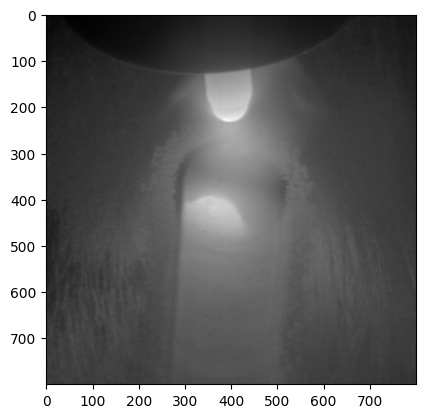

-------------------xxxx--------------------------
=> Image No : 2
 Type of Weld : Defective Weld
 Actual Defect :  Burn through
 Predicted Defect :  Good Weld


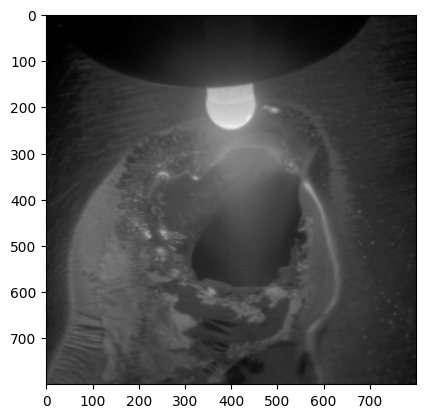

-------------------xxxx--------------------------
=> Image No : 3
 Type of Weld : Defective Weld
 Actual Defect : Lack of fusion
 Predicted Defect :  Contamination


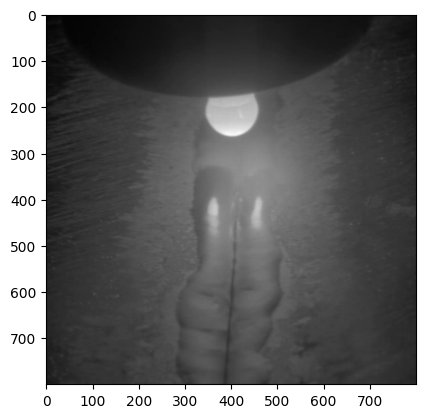

-------------------xxxx--------------------------
=> Image No : 4
 Type of Weld : Defective Weld
 Actual Defect : Contamination
 Predicted Defect :  Lack of fusion


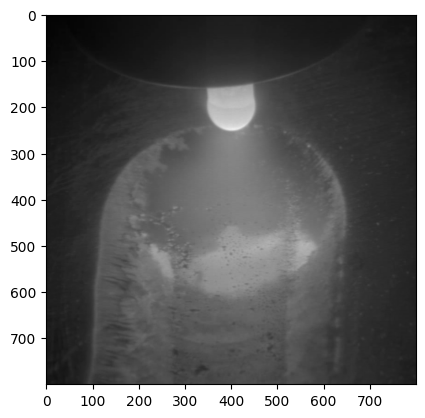

-------------------xxxx--------------------------
=> Image No : 5
 Type of Weld : Good Weld
 Actual Defect : Good Weld
 Predicted Defect :  Contamination


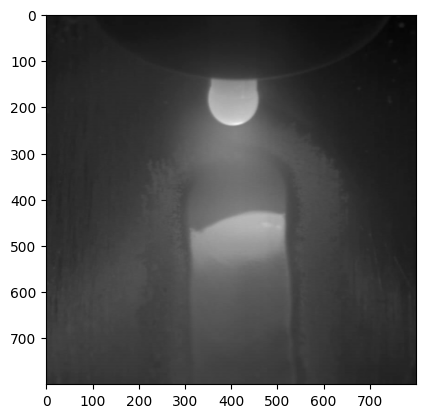

-------------------xxxx--------------------------
=> Image No : 6
 Type of Weld : Good Weld
 Actual Defect : Good Weld
 Predicted Defect :  Contamination


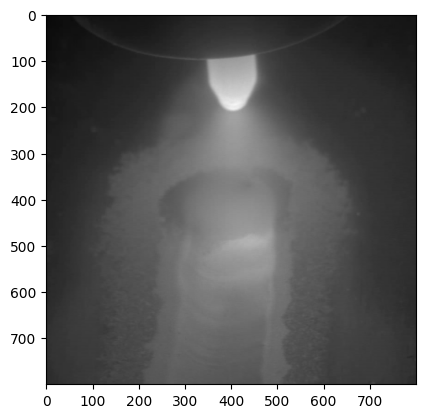

-------------------xxxx--------------------------
=> Image No : 7
 Type of Weld : Defective Weld
 Actual Defect : Lack of fusion
 Predicted Defect :  Contamination


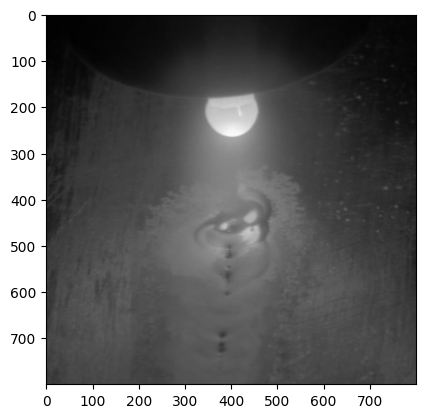

-------------------xxxx--------------------------
=> Image No : 8
 Type of Weld : Good Weld
 Actual Defect : Good Weld
 Predicted Defect :  Contamination


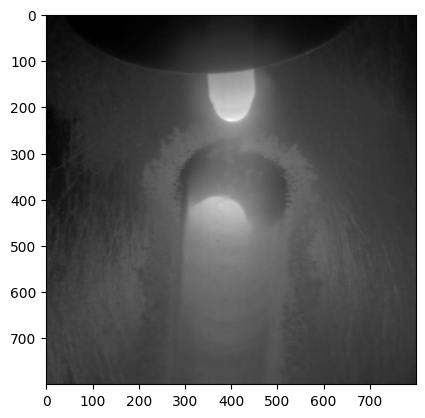

-------------------xxxx--------------------------
=> Image No : 9
 Type of Weld : Defective Weld
 Actual Defect : Contamination
 Predicted Defect :  Contamination


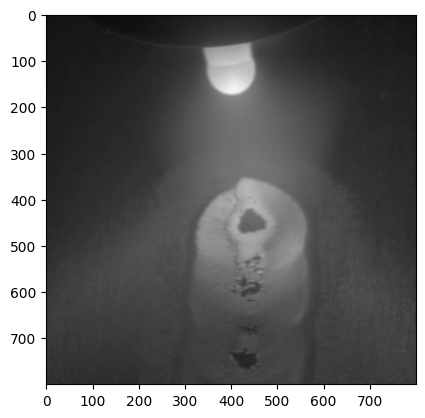

-------------------xxxx--------------------------
=> Image No : 10
 Type of Weld : Good Weld
 Actual Defect : Good Weld
 Predicted Defect :  Contamination


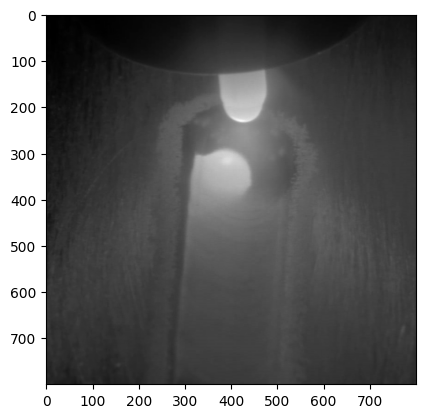

-------------------xxxx--------------------------


In [21]:
for i in range(len(pred_6class)):
  print('=> Image No :',i+1)
  img= image[i]
  print(' Type of Weld :', weld_type[label_6class[i].item()])
  print(' Actual Defect :', defect_label[label_6class[i].item()])
  print(' Predicted Defect : ',defect_label[pred_6class[i].item()])
  plt.imshow(  img.permute(1, 2, 0)  )
  plt.show()
  print('-------------------xxxx--------------------------')